In [1]:
from utils import LoginCredentials
import wandb

authenticator = LoginCredentials()

wandb.login(key=authenticator.wandb_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: finnhenri-smidt. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/henrismidt/.netrc


True

In [2]:
import torch
from torchvision import transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
import wandb


from dataset import MRIImageDataModule, MRIDataset
from models import MobileViTLightning
from utils import get_best_device
from datetime import datetime


import lightning.pytorch as pl
import torch
import numpy as np
import random

def set_reproducibility(seed=42):
    # Set Python random seed
    random.seed(seed)
    
    # Set Numpy seed
    np.random.seed(seed)
    
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # If using CUDA:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Control sources of nondeterminism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # PyTorch Lightning utility to seed everything
    pl.seed_everything(seed, workers=True)

# Example of setting up a reproducible environment
set_reproducibility(42)


Seed set to 42


## Configure Dataloader

In [3]:
from transformers import MobileViTImageProcessor
# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    # Use MobileViTImageProcessor for preprocessing
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

csv_path = 'Data/metadata_for_preprocessed_files.csv'
data_module = MRIImageDataModule(csv_path, slice_number=70, transform=transform, batch_size=1)
data_module.setup()
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)
print(type(model)) 
trainer = L.Trainer(max_epochs=5, devices='auto', accelerator='auto')
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/

<class 'models.mobilevit_lightning.MobileViTLightning'>


Training: |          | 0/? [00:00<?, ?it/s]

/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:58: PerformanceWarning: indexing past lexsort depth may impact performance.
  rows = self.df.loc[(id, slice_num)]
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:47: PerformanceWarning: indexing past lexsort depth may impact performance.
  float_label = self.df.loc[(id, self.slice_number)]['CDR'].iloc[0]
/Users/henrismidt/Documents/Informatik/Master/Alzheimer_Detection/dataset.py:49: PerformanceWarning: indexing past lexsort depth may impact performance.
  age = torch.tensor(self.df.loc[(id, self.slice_number)]['Age']).float()
`Trainer.fit` stopped: `max_epochs=5` reached.


# WandB Sweeps

In [6]:
import os
import torch

# Define the sweep configuration
sweep_config = {
  "method": "grid", 
  "metric": { 
    'name': 'val_loss',
    "goal": "minimize"  
  },
  "parameters": { 
    "epochs": {"values": [10]},
  }
}

# Custom callback for tracking and saving the best model with unique names
class BestModelSaver(L.Callback):
    def __init__(self):
        self.best_val_loss = float('inf')
        self.checkpoint_dir = "model_checkpoints"
        # Use the current timestamp as a unique identifier for each training run
        self.run_id = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    def on_validation_end(self, trainer, pl_module):
        current_val_loss = trainer.callback_metrics['val_loss'].item()

        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss

            os.makedirs(self.checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(self.checkpoint_dir, f"best_model_{self.run_id}_epoch={trainer.current_epoch}.ckpt")

            torch.save(pl_module.state_dict(), checkpoint_path)

            # Optionally, log the model checkpoint in W&B with a unique name
            wandb.log_artifact(checkpoint_path, type='model', name=f'bestModel{trainer.current_epoch}')


# Function to be called for each sweep
def train():
    # Initialize a W&B run
    wandb.init()

    # Access sweep parameters
    config = wandb.config
    epochs = config.epochs

    # Model initialization (modified to use config parameters)
    model = EfficientNetBaseline()
    # Initialize the WandbLogger
    wandb_logger = WandbLogger(project="Baseline", entity="Alzheimer Detection")

    # Best model saver initialization
    best_model_saver = BestModelSaver()

    # Trainer initialization
    trainer = L.Trainer(
        max_epochs=epochs,
    #    logger=wandb_logger,
    #    callbacks=[best_model_saver],  # Add the custom callback
    )

    # Fit the model
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    # torch.save(cinn.state_dict(), f'txt_to_img_{hidden_size}_{n_blocks}.pth')

    # Close the W&B run when done
    wandb.finish()


In [7]:
# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_config, project="Alzheimer Detection", entity="Slice Selection")

# Start sweep
wandb.agent(sweep_id, train, count=9) 


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Create sweep with ID: g1zo2lqu
Sweep URL: https://wandb.ai/network-to-network/cINN-Text-to-Image/sweeps/g1zo2lqu


wandb: Agent Starting Run: mw2x3oc6 with config:
wandb: 	epochs: 40
wandb: 	hidden_size: 128
wandb: 	n_blocks: 15
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: finnhenri-smidt (network-to-network). Use `wandb login --relogin` to force relogin
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELIS

/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type          | Params
------------------------------------------------------
0 | coupling_blocks     | ModuleList    | 1.2 M 
1 | orthogonal_matrices | ParameterList | 57.3 K
------------------------------------------------------
1.2 M     Trainable params
57.3 K    Non-trainable params
1.2 M     Total params
4.918     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.92it/s]

/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 39: 100%|██████████| 240/240 [00:15<00:00, 15.43it/s, v_num=3oc6]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 240/240 [00:15<00:00, 15.37it/s, v_num=3oc6]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
min_val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
min_val_loss,-0.20349
train_loss,1.73346
trainer/global_step,9599
val_loss,8.11831


wandb: Agent Starting Run: fryig3yj with config:
wandb: 	epochs: 40
wandb: 	hidden_size: 128
wandb: 	n_blocks: 30
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type          | Params
------------------------------------------------------
0 | coupling_blocks     | ModuleList    | 2.3 M 
1 | orthogonal_matrices | ParameterList | 118 K 
------------------------------------------------------
2.3 M     Trainable params
118 K     Non-trainable params
2.5 M     Total params
9.852     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.46it/s]

/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 39: 100%|██████████| 240/240 [00:35<00:00,  6.81it/s, v_num=g3yj]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 240/240 [00:35<00:00,  6.79it/s, v_num=g3yj]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
min_val_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
train_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,39
min_val_loss,-0.57055
train_loss,-10.0814
trainer/global_step,9599
val_loss,6.86887


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewu3mxmy with config:
wandb: 	epochs: 40
wandb: 	hidden_size: 256
wandb: 	n_blocks: 50
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type          | Params
------------------------------------------------------
0 | coupling_blocks     | ModuleList    | 9.4 M 
1 | orthogonal_matrices | ParameterList | 200 K 
------------------------------------------------------
9.4 M     Trainable params
200 K     Non-trainable params
9.7 M     Total params
38.601    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/henrismidt/anaconda3/envs/gnn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 39: 100%|██████████| 240/240 [00:48<00:00,  4.98it/s, v_num=mxmy]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 240/240 [00:48<00:00,  4.96it/s, v_num=mxmy]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
min_val_loss,█▇▇▅▄▃▂▂▂▁
train_loss,▇▇█▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▆▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▄▄
epoch,39
min_val_loss,-1.58059
train_loss,-22.40546
trainer/global_step,9599
val_loss,14.21215


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
import torch
from torchvision import transforms
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from transformers import MobileViTImageProcessor
import wandb

from dataset import MRIImageDataModule, MRIDataset
from models import MobileViTLightning
from utils import get_best_device, LoginCredentials

from datetime import datetime
import lightning.pytorch as pl
import torch
import numpy as np
import random
from sklearn.metrics import f1_score

authenticator = LoginCredentials()
wandb.login(key=authenticator.wandb_key)

def set_reproducibility(seed=42):
    # Set Python random seed
    random.seed(seed)
    
    # Set Numpy seed
    np.random.seed(seed)
    
    # Set PyTorch seed
    torch.manual_seed(seed)
    
    # If using CUDA:
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Control sources of nondeterminism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # PyTorch Lightning utility to seed everything
    pl.seed_everything(seed, workers=True)

# Example of setting up a reproducible environment
set_reproducibility(42)

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    # Use MobileViTImageProcessor for preprocessing
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Define sweep configuration
sweep_config = {
    'method': 'grid',
    'parameters': {
        'slice_number': {
            'values': list(range(20, 140, 3))  # Values: 20, 17, 14
        }
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project="Alzheimer-Detection")

# Define the training function
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        data_module = MRIImageDataModule(csv_path, slice_number=config.slice_number, transform=transform, batch_size=48, num_workers=0)
        data_module.setup()
        train_loader = data_module.train_dataloader()
        val_loader = data_module.val_dataloader()
        test_loader = data_module.test_dataloader()

        model = MobileViTLightning(model_ckpt=model_ckpt, num_labels=4)

        wandb_logger = WandbLogger()

        checkpoint_callback = ModelCheckpoint(
            dirpath='model_checkpoints',
            filename=f'slice_numer_{config.slice_number}',
            monitor='val_loss',
            mode='min',
            save_top_k=1
        )

        trainer = L.Trainer(
            max_epochs=20,
            devices='auto',
            accelerator='auto',
            logger=wandb_logger,
            callbacks=[checkpoint_callback],
            log_every_n_steps=24
        )

        trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

        # Load best model for testing
        # best_model_path = checkpoint_callback.best_model_path
        # best_model = MobileViTLightning.load_from_checkpoint(best_model_path, model_ckpt=model_ckpt, num_labels=4)

        # # Evaluate on test set
        # best_model.eval()
        # all_preds = []
        # all_labels = []
        # for batch in test_loader:
        #     inputs, labels = batch
        #     outputs = best_model(inputs)
        #     preds = torch.argmax(outputs, dim=1)
        #     all_preds.extend(preds.cpu().numpy())
        #     all_labels.extend(labels.cpu().numpy())

        # f1 = f1_score(all_labels, all_preds, average='weighted')
        # wandb.log({'test_f1_score': f1})

# Run the sweep
wandb.agent(sweep_id, function=train)


In [3]:
import torch
import pandas as pd
from transformers import MobileViTImageProcessor
from sklearn.metrics import f1_score
import os
from dataset import MRIImageDataModule
from models import MobileViTLightning
from utils import get_best_device


# Set device
device = get_best_device()

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Function to evaluate a model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, age = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return f1_score(all_labels, all_preds, average='weighted')

# List to store the results
results = []

# Iterate over the saved models
for slice_number in range(20, 140, 3):
    model_path = f'model_checkpoints/slice_numer_{slice_number}.ckpt'
    if not os.path.exists(model_path):
        continue
    # Load the model
    model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
    model = model.to(device)
    # Initialize the data module
    data_module = MRIImageDataModule(csv_path, slice_number=slice_number, transform=transform, batch_size=48, num_workers=0)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    # Evaluate the model
    f1 = evaluate_model(model, test_loader)
    
    # Append the result
    results.append({'slice_number': slice_number, 'f1_score': f1})

# Create a DataFrame
df = pd.DataFrame(results)

# Save the DataFrame
df.to_csv('model_evaluation_results.csv', index=False)


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprec

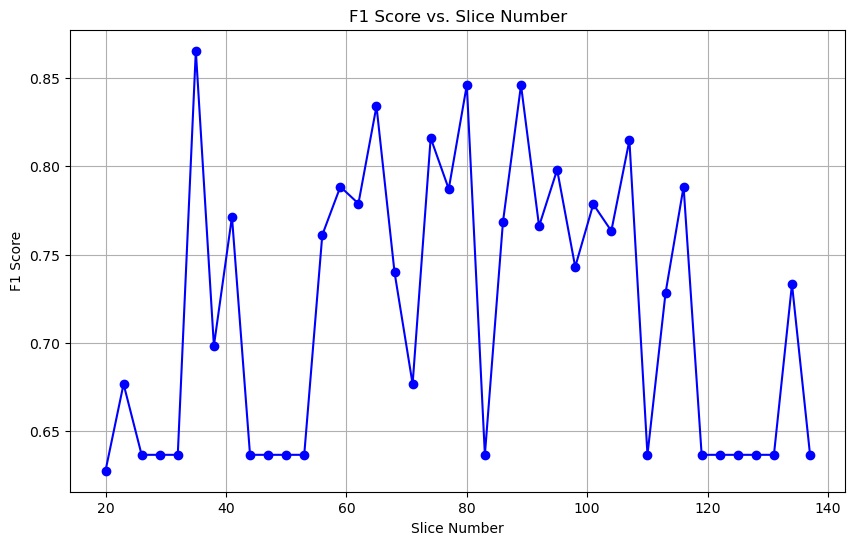

In [4]:
import matplotlib.pyplot as plt

# Plot the F1 score against the slice number
plt.figure(figsize=(10, 6))
plt.plot(df['slice_number'], df['f1_score'], marker='o', linestyle='-', color='b')
plt.title('F1 Score vs. Slice Number')
plt.xlabel('Slice Number')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [6]:
import torch
import pandas as pd
from transformers import MobileViTImageProcessor
from sklearn.metrics import f1_score
import os
import numpy as np
import matplotlib.pyplot as plt
from dataset import MRIImageDataModule
from models import MobileViTLightning
from utils import get_best_device

# Set device
device = get_best_device()

# Load the preprocessor
model_ckpt = "apple/mobilevit-x-small"
processor = MobileViTImageProcessor.from_pretrained(model_ckpt)

# Load and preprocess the CIFAR-10 dataset
def transform(image):
    return processor(image, return_tensors="pt")["pixel_values"].squeeze(0)

# Path to the CSV file
csv_path = 'Data/metadata_for_preprocessed_files.csv'

# Function to evaluate a model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels, age = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    per_class_f1 = f1_score(all_labels, all_preds, average=None)
    return weighted_f1, per_class_f1

# List to store the results
results = []

# Iterate over the saved models
for slice_number in range(20, 140, 3):
    model_path = f'model_checkpoints/slice_numer_{slice_number}.ckpt'
    if not os.path.exists(model_path):
        continue
    # Load the model
    model = MobileViTLightning.load_from_checkpoint(model_path, model_ckpt=model_ckpt, num_labels=4)
    model = model.to(device)
    # Initialize the data module
    data_module = MRIImageDataModule(csv_path, slice_number=slice_number, transform=transform, batch_size=48, num_workers=0)
    data_module.setup()
    test_loader = data_module.test_dataloader()
    # Evaluate the model
    weighted_f1, per_class_f1 = evaluate_model(model, test_loader)
    
    # Append the result
    result = {'slice_number': slice_number, 'weighted_f1_score': weighted_f1}
    for i, class_f1 in enumerate(per_class_f1):
        result[f'class_{i}_f1_score'] = class_f1
    results.append(result)

# Create a DataFrame
df = pd.DataFrame(results)

# Save the DataFrame
df.to_csv('model_evaluation_results.csv', index=False)

# Plot the F1 score against the slice number
plt.figure(figsize=(12, 8))

# Plot weighted F1 score
plt.plot(df['slice_number'], df['weighted_f1_score'], marker='o', linestyle='-', label='Weighted F1 Score')

# Plot per-class F1 scores
for i in range(4):  # Assuming 4 classes
    if f'class_{i}_f1_score' in df.columns:
        plt.plot(df['slice_number'], df[f'class_{i}_f1_score'], marker='o', linestyle='-', label=f'Class {i} F1 Score')

plt.title('F1 Score vs. Slice Number')
plt.xlabel('Slice Number')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-x-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/henrismidt/anaconda3/envs/alzheimer/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprec